# Problem 3

In [2]:
import load_helper

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import importlib

from torch import tensor

In [53]:
fname = '3.daphne'
graph = load_helper.graph_helper(fname)
%cat 3.daphne

(let [data [1.1 2.1 2.0 1.9 0.0 -0.1 -0.05]
      likes (foreach 3 []
                     (let [mu (sample (normal 0.0 10.0))
                           sigma (sample (gamma 1.0 1.0))]
                       (normal mu sigma)))
      pi (sample (dirichlet [1.0 1.0 1.0]))
      z-prior (discrete pi)
      z (foreach 7 [y data]
          (let [z (sample z-prior)
                _ (observe (get likes z) y)]
            z))]
  (= (first z) (second z)))

In [16]:
import bbvi
importlib.reload(bbvi)

from bbvi import graph_bbvi_algo12

In [34]:
%%time
T=1000
L=100
lr=0.05
r, logW, sigma = bbvi.graph_bbvi_algo12(graph,T=T,L=L,lr=lr,
                                   do_log=False)

t=0, Q after step={'sample3': Gamma(concentration: 1.0499999523162842, rate: 0.54132479429245), 'sample1': Gamma(concentration: 1.0499999523162842, rate: 0.54132479429245), 'sample2': Normal(loc: -0.05000000074505806, scale: 9.999954223632812), 'sample4': Normal(loc: -0.04999999701976776, scale: 9.999954223632812), 'sample6': Dirichlet(concentration: torch.Size([3])), 'sample11': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample13': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample19': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample15': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample9': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample7': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample17': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample0': Normal(loc: 0.05000000074505806, scale: 9.999954223632812), 'sample5': Gamma(concentration: 0.94999998

t=800, Q after step={'sample3': Gamma(concentration: 1.9163165092468262, rate: 0.2426215559244156), 'sample1': Gamma(concentration: 2.2835867404937744, rate: 0.1482381969690323), 'sample2': Normal(loc: 0.3498328626155853, scale: 9.097940444946289), 'sample4': Normal(loc: 0.4434855282306671, scale: 8.850457191467285), 'sample6': Dirichlet(concentration: torch.Size([3])), 'sample11': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample13': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample19': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample15': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample9': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample7': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample17': Categorical(probs: torch.Size([3]), logits: torch.Size([3])), 'sample0': Normal(loc: 1.0016863346099854, scale: 8.960394859313965), 'sample5': Gamma(concentration: 2.0418074

Text(0.5, 1.0, '3.daphne  \n Best ELBO -56.82 \n T=1000 | L=100 | Adam, lr=0.05 ')

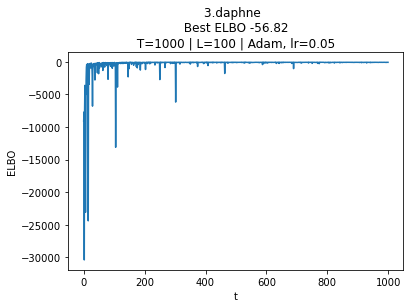

In [36]:
elbo = logW.mean(1)
pd.Series(elbo).plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{}  \n Best ELBO {:1.2f} \n T={} | L={} | Adam, lr={} '.format(fname,elbo.max(),T,L,lr))

In [37]:
r_array = np.array(r)

Text(0.5, 1.0, '3.daphne  \n Best ELBO -56.82 \n T=1000 | L=100 | Adam, lr=0.05 ')

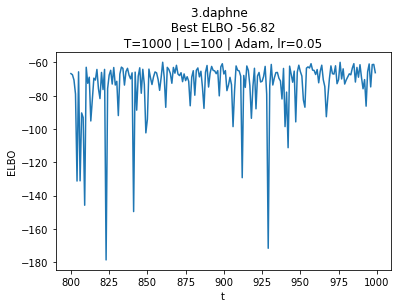

In [39]:
sr = pd.Series(elbo[-200:])
sr.index = np.arange(elbo.size-200,elbo.size)
sr.plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{}  \n Best ELBO {:1.2f} \n T={} | L={} | Adam, lr={} '.format(fname,elbo.max(),T,L,lr))

In [42]:
probs = np.exp(logW)
probs /= probs.sum()
probs = probs.reshape(T,L)
posterior_r = (probs * r_array).sum(axis=(0,1))
posterior_r2 = (probs * r_array**2).sum(axis=(0,1))

std_r = np.sqrt(posterior_r2 - posterior_r**2)

In [51]:
print('{} expected posterior z1==z2 {:1.3f} | std posterior z1==z2 {:1.3f}'.format(fname,posterior_r,std_r))

3.daphne expected posterior z1==z2 0.049 | std posterior z1==z2 0.215


**Also write a paragraph or two about the mode-seeking behavior of VI on models like this that have internal symmetries. Note what the symmetries are and why they might cause problems with optimization.**

This problem is a Gaussian mixture model. As discussed in office hours, the choice of KL(p||q) instead of KL(q||q) makes us snap to one mode, in this multimodal problem. See the inclusive divergence and exclusive divergence remarks on [Stefano Ermon's Probabilistic Graphical Models Winter class (Stanford 2020-21)](https://ermongroup.github.io/cs228-notes/inference/variational/). This GMM problem is multimodal, because there is no meaning to the cluster labels attached to the data points, they are just arbitrary labels. Stochastically, if some datapoints are relabelled, the cluster can shift in the sense that, the labels can swap between clusters. When this is happening in the algorithm, we are "jumping out" of a local minima, and "jumping into" another.